In [4]:
import scanpy as sc
import scvi 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

/Users/adorman/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
adata_path = "lung_atlas.h5ad"

adata = sc.read_h5ad(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [11]:
adata.obs
#np.unique(adata.obs.dataset)

dataset  \
index                                                                    
GAGGGGCCAGCC                                        Dropseq_transplant   
ACATAGATAGGC                                        Dropseq_transplant   
ATCGACGCGGCA                                        Dropseq_transplant   
CCAGCTTAGGTT                                        Dropseq_transplant   
TCATAGAGTCCT                                        Dropseq_transplant   
...                                                                ...   
LungTranscriptome7239219_LungTranscriptome72392...      10x_Transplant   
LungTranscriptome7239219_LungTranscriptome72392...      10x_Transplant   
LungTranscriptome7239213_GACTGCGTCCTGCCAT               10x_Transplant   
LungTranscriptome7239218_GCTGCGACATTCACTT               10x_Transplant   
LungTranscriptome7239219_LungTranscriptome72392...      10x_Transplant   

                                                         location  nGene  \
index                                                                      
GAGGGGCCAGCC                                        Dropseq_lower    249   
ACATAGATAGGC                                        Dropseq_lower    582   
ATCGACGCGGCA                                        Dropseq_lower    292   
CCAGCTTAGGTT                                        Dropseq_lower   1057   
TCATAGAGTCCT                                        Dropseq_lower    716   
...                                                           ...    ...   
LungTranscriptome7239219_LungTranscriptome72392...     Transplant   1178   
LungTranscriptome7239219_LungTranscriptome72392...     Transplant   1919   
LungTranscriptome7239213_GACTGCGTCCTGCCAT              Transplant   4411   
LungTranscriptome7239218_GCTGCGACATTCACTT              Transplant   2132   
LungTranscriptome7239219_LungTranscriptome72392...     Transplant   1886   

                                                     nUMI patientGroup  \
index                                                                    
GAGGGGCCAGCC                                          355          nan   
ACATAGATAGGC                                          987          nan   
ATCGACGCGGCA                                          490          nan   
CCAGCTTAGGTT                                         1806          nan   
TCATAGAGTCCT                                         1378          nan   
...                                                   ...          ...   
LungTranscriptome7239219_LungTranscriptome72392...   3245   Parenchyma   
LungTranscriptome7239219_LungTranscriptome72392...   5984   Parenchyma   
LungTranscriptome7239213_GACTGCGTCCTGCCAT           25233   Parenchyma   
LungTranscriptome7239218_GCTGCGACATTCACTT            7216   Parenchyma   
LungTranscriptome7239219_LungTranscriptome72392...   5846   Parenchyma   

                                                    percent.mito  protocol  \
index                                                                        
GAGGGGCCAGCC                                            0.019718  drop-seq   
ACATAGATAGGC                                            0.044580  drop-seq   
ATCGACGCGGCA                                            0.026531  drop-seq   
CCAGCTTAGGTT                                            0.035437  drop-seq   
TCATAGAGTCCT                                            0.020319  drop-seq   
...                                                          ...       ...   
LungTranscriptome7239219_LungTranscriptome72392...      0.011896    10x v2   
LungTranscriptome7239219_LungTranscriptome72392...      0.018747    10x v2   
LungTranscriptome7239213_GACTGCGTCCTGCCAT               0.010489    10x v2   
LungTranscriptome7239218_GCTGCGACATTCACTT               0.013827    10x v2   
LungTranscriptome7239219_LungTranscriptome72392...      0.017164    10x v2   

                                                   sanger_type  size_factors  \
index                                                

# Try integration using scvi

## Load all the datasets and concatante into one object

In [2]:
dir_name = ['D8_1','D8_2','D12_1','D12_2','D20_1', 'D20_2', 'D22_1', 'D22_2']

adatasets = []
for name in dir_name:

    exec(f"adata_tmp = sc.read_10x_mtx('../data/initial_10x_outputs/' + 'filtered_feature_bc_matrix-' + name)")

    #sc.pl.highest_expr_genes(adata_tmp, n_top=20)

    #Basic filtering genes not expressed + cell with too few genes
    sc.pp.filter_cells(adata_tmp, min_genes=200)
    sc.pp.filter_genes(adata_tmp, min_cells=3)

    #Define the mitochondrial genes + compute QC metrics
    adata_tmp.var["mt"] = adata_tmp.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata_tmp, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    
    #Visualization QC metrics
    """ plt.hist(adata_tmp.obs.n_genes, bins=50)
    plt.title("Number of genes per cell")
    plt.show()

    plt.hist(adata_tmp.obs.pct_counts_mt, bins=50)
    plt.title("Percentage of mitochodrial genes per cells")
    plt.show() """

    #sc.pl.scatter(adata_tmp, x="total_counts", y="n_genes_by_counts")

    #Filter cells 
    #Remove all cell with % mt > 20% + extreme total counts
    adata_tmp = adata_tmp[adata_tmp.obs.pct_counts_mt < 20]
    adata_tmp = adata_tmp[adata_tmp.obs.total_counts < 100000]
    adata_tmp = adata_tmp[np.logical_and(adata_tmp.obs.n_genes > 900,adata_tmp.obs.n_genes < 6000)]
    
    adatasets.append(adata_tmp)        
    

adata = adatasets[0]


In [5]:
adata = adata.concatenate(adatasets[1:], join="outer")

#Feature selection 
sc.pp.highly_variable_genes(adata, 
                            n_top_genes=5000,
                            flavor='seurat_v3',
                            batch_key='batch'
)

adata = adata[:, adata.var.highly_variable].copy()

adata

/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_76232/3845947206.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adatasets[1:], join="outer")


AnnData object with n_obs × n_vars = 100742 × 5000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mt-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'mt-5', 'n_cells_by_counts-5', 'mean_counts-5', 'pct_dropout_by_counts-5', 'total_counts-5', 'gene

In [6]:
adata.obs.batch

AAACAGCCAAACGCGA-1-0    0
AAACAGCCACAGGAAT-1-0    0
AAACAGCCACATGCTA-1-0    0
AAACAGCCAGGCCATT-1-0    0
AAACAGCCATCCGTAA-1-0    0
                       ..
TTTGTGTTCCCGTTGT-1-7    7
TTTGTGTTCGTAATCA-1-7    7
TTTGTTGGTCCGCTGT-1-7    7
TTTGTTGGTGTGAGAG-1-7    7
TTTGTTGGTTTGGTTC-1-7    7
Name: batch, Length: 100742, dtype: category
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

## Set up of model for scvi

In [8]:
# Set up the model for scvi
adata.layers["counts"] = adata.X.copy()  
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key='batch'
)


In [9]:
model = scvi.model.SCVI(adata)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [10]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Applications/anaconda3/envs/LeKIra/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 79/79: 100%|██████████| 79/79 [2:12:38<00:00, 112.62s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=2.26e+3]  

`Trainer.fit` stopped: `max_epochs=79` reached.


Epoch 79/79: 100%|██████████| 79/79 [2:12:38<00:00, 100.74s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=2.26e+3]


In [11]:
model_dir =  "../data/scvi_model"
model.save(model_dir, overwrite=True)

## Use latent representation from model to cluster datasets

In [12]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(100742, 10)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


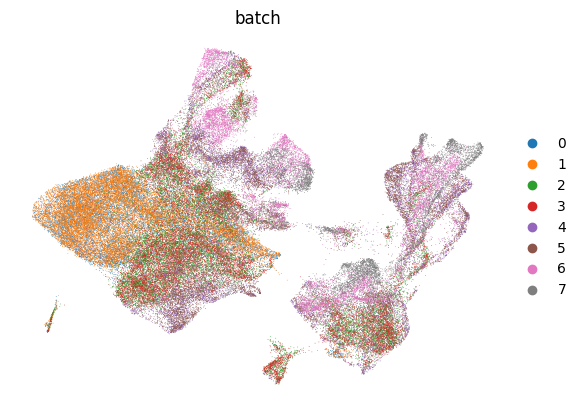

In [14]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["batch"],
    frameon=False
)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


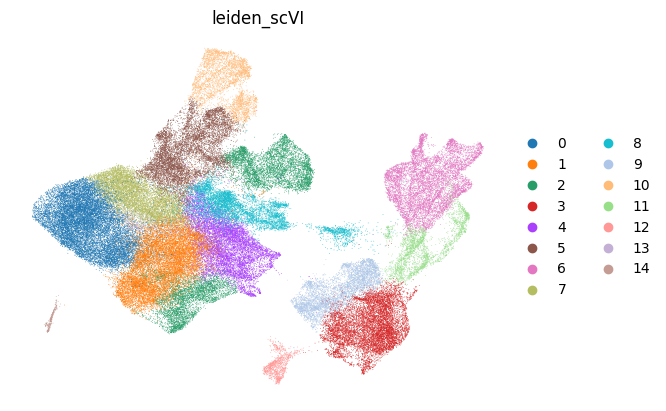

In [16]:
#Cluster on latent space
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


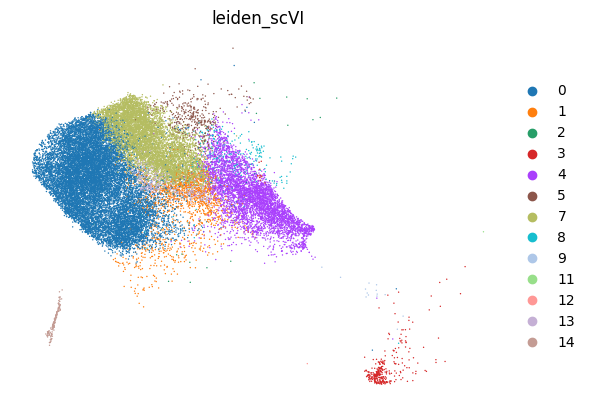

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


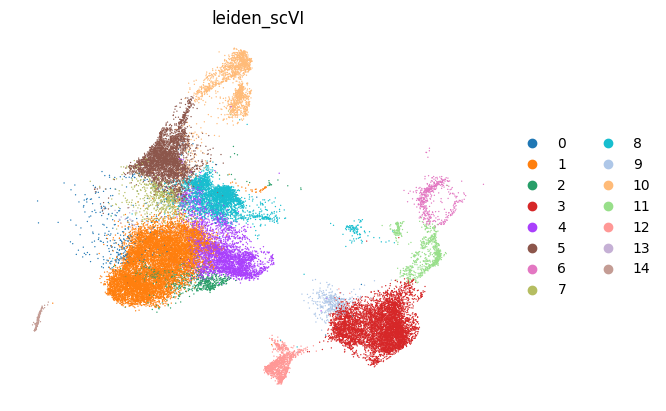

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


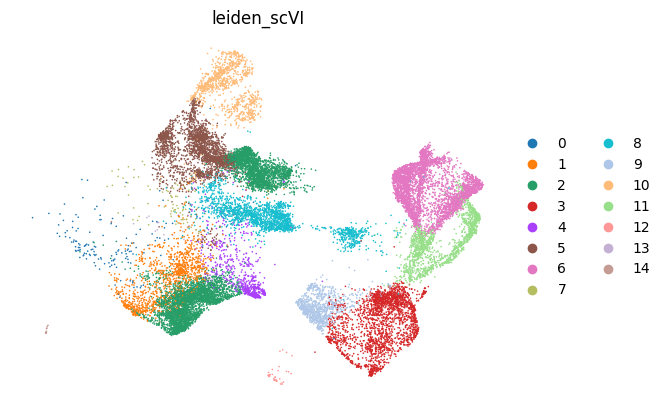

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


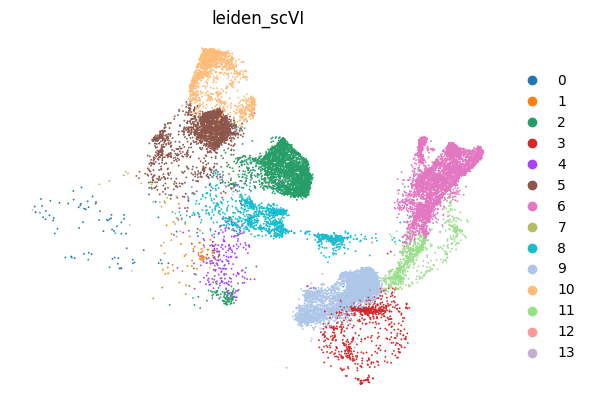

In [25]:
sc.pl.umap(
    adata[np.logical_or(adata.obs.batch == '0', adata.obs.batch == '1')],
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)
sc.pl.umap(
    adata[np.logical_or(adata.obs.batch == '2', adata.obs.batch == '3')],
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)
sc.pl.umap(
    adata[np.logical_or(adata.obs.batch == '4', adata.obs.batch == '5')],
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)
sc.pl.umap(
    adata[np.logical_or(adata.obs.batch == '6', adata.obs.batch == '7')],
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

In [27]:
# Normalize + log transform
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

/Users/adorman/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new im

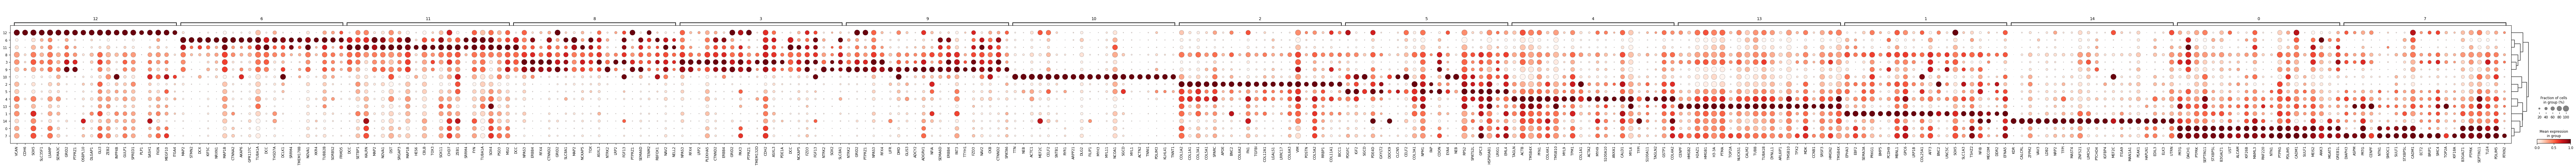

In [44]:
sc.tl.rank_genes_groups(adata, groupby=SCVI_CLUSTERS_KEY, method="wilcoxon")

sc.pl.rank_genes_groups_dotplot(
    adata, groupby=SCVI_CLUSTERS_KEY, standard_scale="var", n_genes=20
)

In [49]:
adata

AnnData object with n_obs × n_vars = 100742 × 5000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'n_counts'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mt-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'mt-5', 'n_cells_by_counts-5', 'mean_cou

In [54]:
for i in np.unique(adata.obs.leiden_scVI):
    dedf = sc.get.rank_genes_groups_df(adata, group=i)
    dedf.names.to_csv(('gene_list/' + i + '.csv'), index=False)


/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=Tr

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=Tr

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


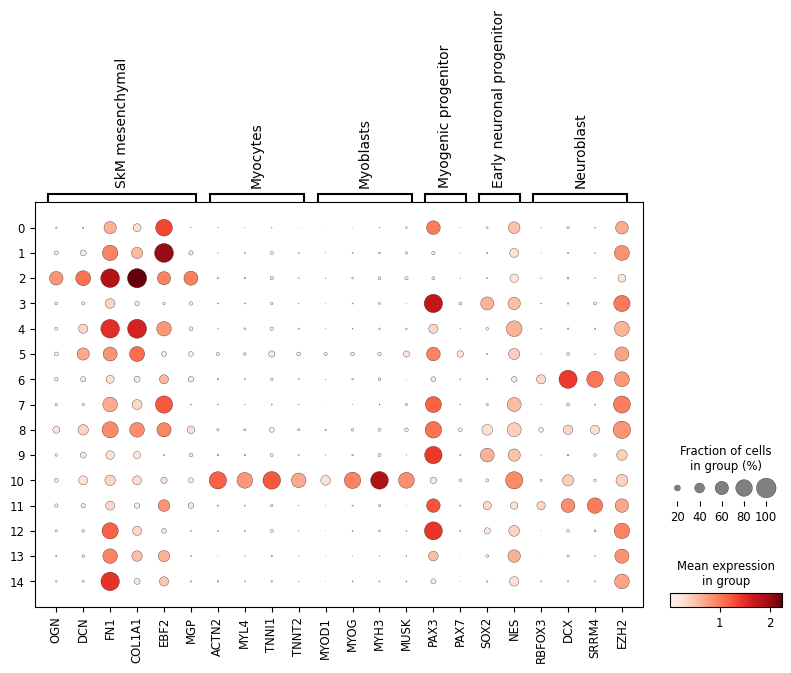

In [29]:
marker_genes = {
    "SkM mesenchymal": ["OGN",'DCN','FN1','COL1A1','EBF2','MGP'],
    "Myocytes": ["ACTN2", "MYL4", "TNNI1",'TNNT2'],
    "Myoblasts": ['MYOD1','MYOG','MYH3', 'MUSK'],
    "Myogenic progenitor": ['PAX3','PAX7'],
    "Early neuronal progenitor": ['SOX2','NES'],
    'Neuroblast': ['RBFOX3','DCX','SRRM4','EZH2']
}
sc.pl.dotplot(adata, marker_genes, groupby=SCVI_CLUSTERS_KEY)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


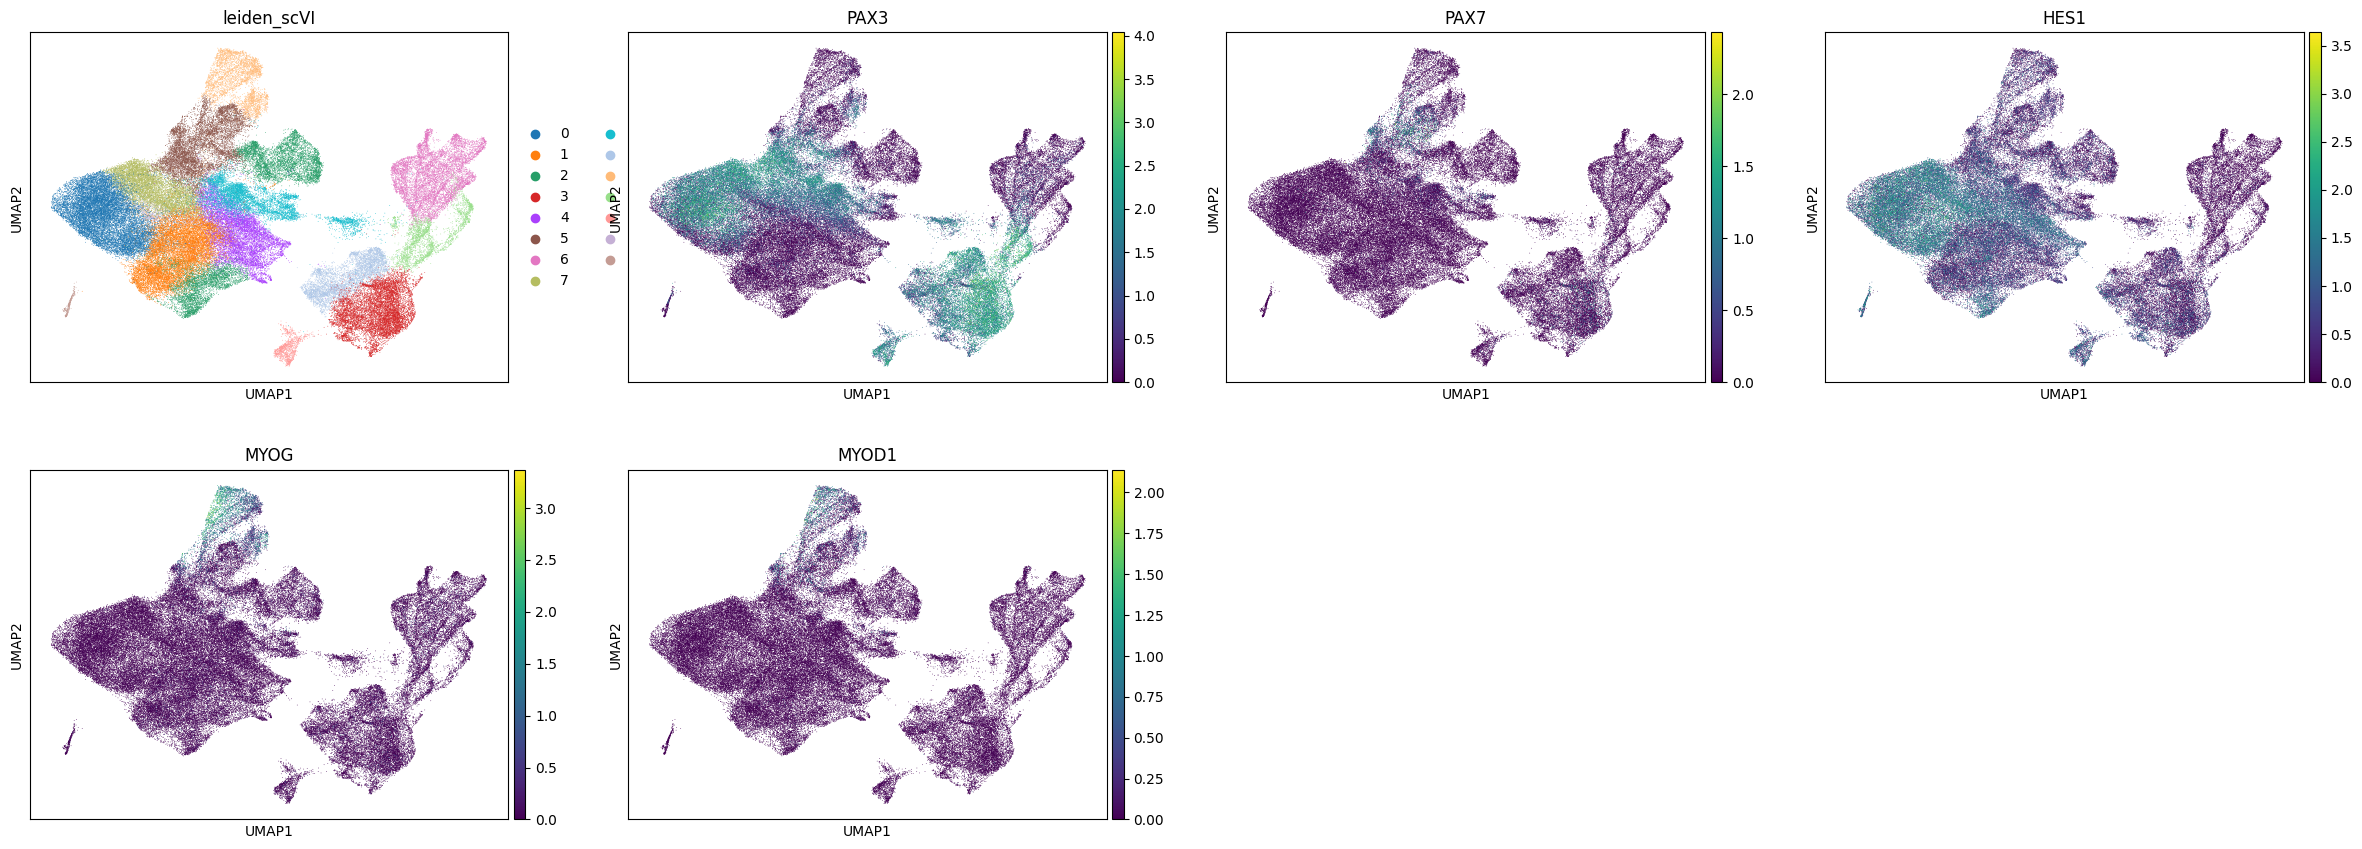

In [46]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY, "PAX3",'PAX7','HES1','MYOG','MYOD1'])

In [58]:
adata.var_names.to_series().to_csv('test.csv', index=False)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


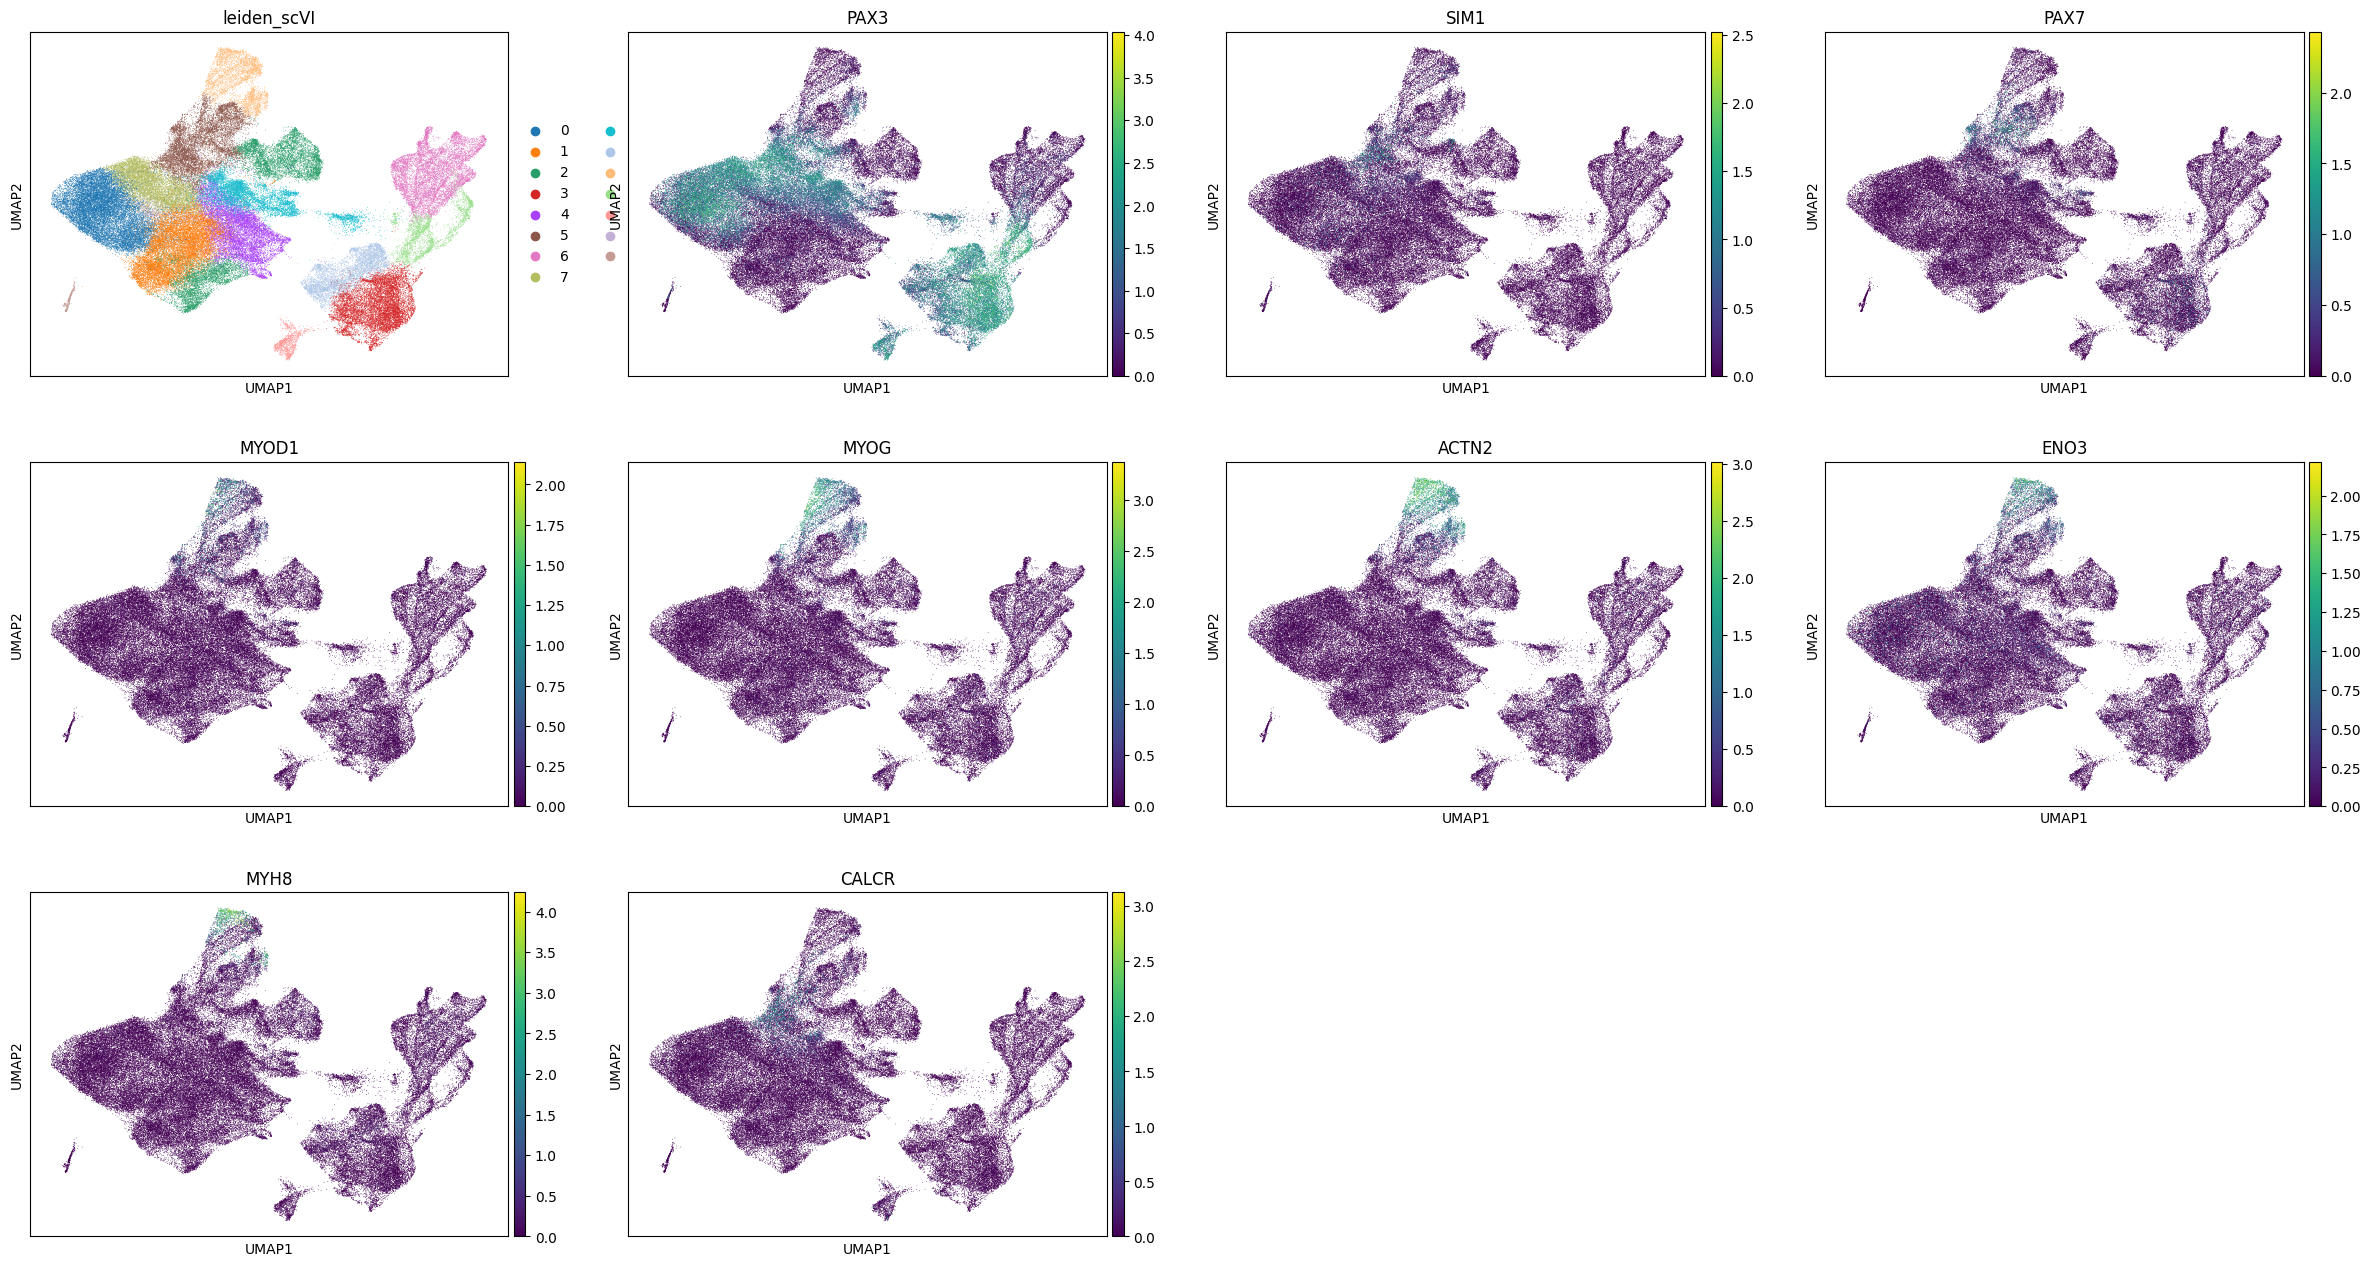

In [61]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY, "PAX3", 'SIM1', 'PAX7', 'MYOD1','MYOG', 
                         'ACTN2', 'ENO3', 'MYH8', 'CALCR'])

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


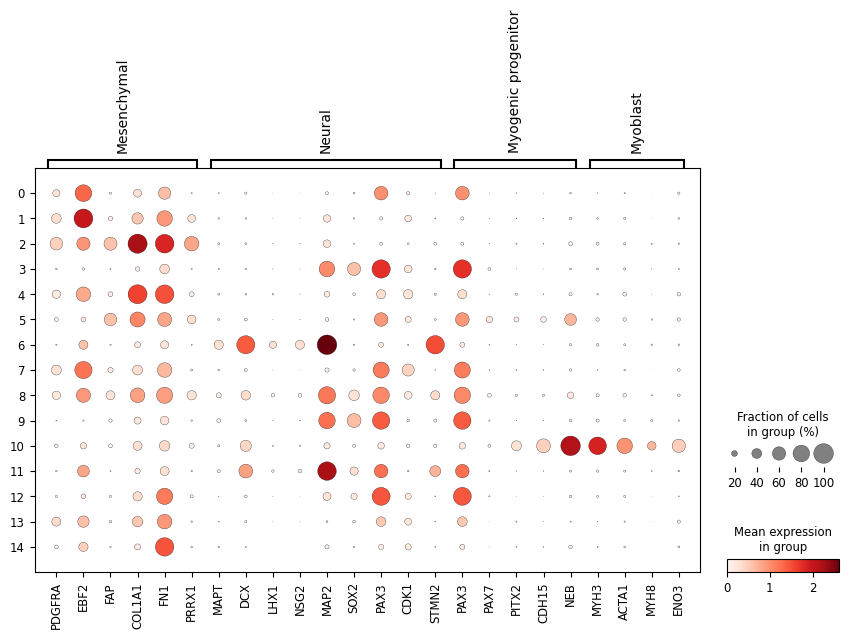

In [67]:
marker_genes = {
    "Mesenchymal": ["PDGFRA",'EBF2','FAP','COL1A1','FN1','PRRX1'],
    "Neural": ["MAPT", "DCX", "LHX1",'NSG2','MAP2','SOX2','PAX3','CDK1','STMN2'],
    "Myogenic progenitor": ['PAX3','PAX7','PITX2','CDH15','NEB'],
    "Myoblast": ['MYH3','ACTA1','MYH8','ENO3'],
}
sc.pl.dotplot(adata, marker_genes, groupby=SCVI_CLUSTERS_KEY)